# Stocks Prediction

In [1]:
import IPython
import IPython.display

import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

matplotlib.rcParams['figure.figsize'] = (12, 8)

## Data

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('./Datasets/huge-stock-market-dataset/Stocks/aal.us.txt', index_col='Date', parse_dates=['Date'], date_parser=dateparse)
print(len(df))
df.head()

989


<ipython-input-3-a74b7add83d5>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2013-12-10,23.698,24.345,23.610,24.064,18043837,0
2013-12-11,24.607,26.288,24.539,25.139,43224764,0
2013-12-12,25.342,25.832,24.616,24.616,20749989,0
2013-12-13,24.771,25.437,24.684,25.369,12588700,0
2013-12-16,25.749,25.888,25.485,25.739,17136729,0


In [4]:
df = df.rename(columns={'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low', 'Volume': 'volume'})
df = df.drop(columns=['OpenInt'])
df.head()

,open,high,low,close,volume
Date,,,,,
2013-12-10,23.698,24.345,23.610,24.064,18043837
2013-12-11,24.607,26.288,24.539,25.139,43224764
2013-12-12,25.342,25.832,24.616,24.616,20749989
2013-12-13,24.771,25.437,24.684,25.369,12588700
2013-12-16,25.749,25.888,25.485,25.739,17136729


In [5]:
df.describe()

,open,high,low,close,volume
count,989.000000,989.000000,989.000000,989.000000,9.890000e+02
mean,41.150250,41.751690,40.537996,41.150520,1.004541e+07
std,6.344948,6.346726,6.284963,6.304682,6.971825e+06
min,23.698000,24.345000,23.610000,23.967000,2.246383e+06
25%,36.770000,37.343000,36.143000,36.809000,6.326115e+06
50%,41.241000,41.741000,40.594000,41.231000,8.685476e+06
75%,46.265000,46.960000,45.695000,46.315000,1.189551e+07
max,54.333000,54.634000,53.624000,54.317000,1.414300e+08


In [6]:
df['change'] = df.close.pct_change()

In [7]:
df[['change', 'close']].head()

,change,close
Date,,
2013-12-10,NaN,24.064
2013-12-11,0.044673,25.139
2013-12-12,-0.020804,24.616
2013-12-13,0.030590,25.369
2013-12-16,0.014585,25.739


In [8]:
df['log_change'] = np.log(1 + df.change)

In [9]:
df.dropna(inplace=True)
df.head()

,open,high,low,close,volume,change,log_change
Date,,,,,,,
2013-12-11,24.607,26.288,24.539,25.139,43224764,0.044673,0.043703
2013-12-12,25.342,25.832,24.616,24.616,20749989,-0.020804,-0.021024
2013-12-13,24.771,25.437,24.684,25.369,12588700,0.030590,0.030131
2013-12-16,25.749,25.888,25.485,25.739,17136729,0.014585,0.014479
2013-12-17,25.605,25.721,25.099,25.245,11260767,-0.019193,-0.019379


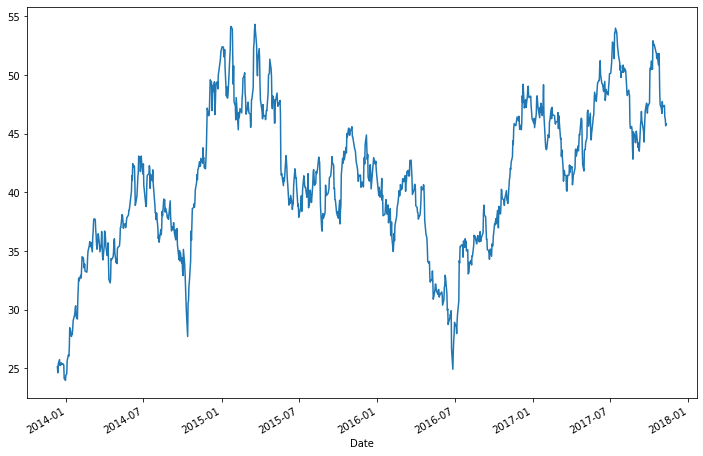

In [10]:
df['close'].plot()
plt.show()

In [11]:
scaler = MinMaxScaler()
df.close = scaler.fit_transform(df.close.values.reshape(-1, 1))
df.open = scaler.fit_transform(df.open.values.reshape(-1, 1))
df.high = scaler.fit_transform(df.high.values.reshape(-1, 1))
df.low = scaler.fit_transform(df.low.values.reshape(-1, 1))
df.volume = scaler.fit_transform(df.volume.values.reshape(-1, 1))
df.change = scaler.fit_transform(df.change.values.reshape(-1, 1))
df.log_change = scaler.fit_transform(df.log_change.values.reshape(-1, 1))

Split the data using (70, 20, 10)

In [12]:
df.isna().sum()

open          0
high          0
low           0
close         0
volume        0
change        0
log_change    0
dtype: int64

In [13]:
df = df[['close', 'log_change']]

In [14]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
num_features

2

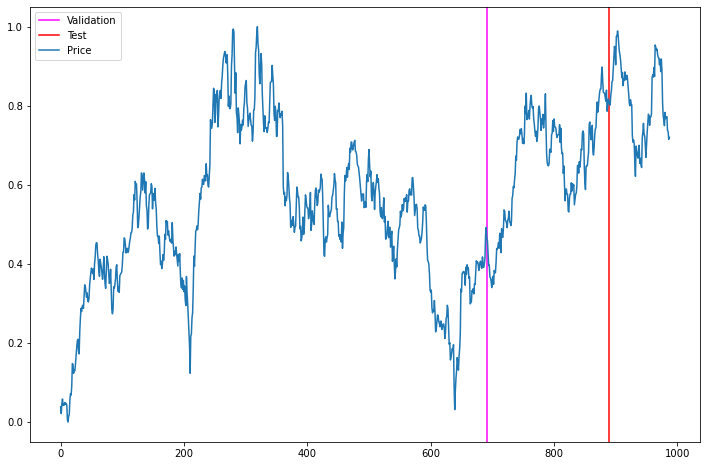

In [15]:
plt.axvline(x=len(train_df), color='magenta')
plt.axvline(x=len(train_df) + len(val_df), color='red')
plt.plot(range(len(df)), df.close)
plt.legend(['Validation', 'Test', 'Price'])
plt.show()

## Window Generator

In [16]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, 
                 val_df=val_df, test_df=test_df, label_columns=None):
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # wirk out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i,
                                          name in enumerate(label_columns)}
        self.column_indices = {name: i for i,
                               name in enumerate(train_df.columns)}
        
        # work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [17]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
def plot(self, model=None, plot_col='close', max_subplots=10, title=None):
    inputs, labels = self.example
    plt.figure(figsize=(24, 32))
    if title:
        plt.suptitle(title)
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_subplots, 2, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()
    
    plt.xlabel('Time')
    plt.show()

WindowGenerator.plot = plot

In [19]:
def plot_series(self, model, plot_col='close', series=test_df, start=0, title=None):
#         plt.figure(figsize=(12, 8))
        
        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(self.total_window_size, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda w: w.batch(self.total_window_size))
        ds = ds.batch(32).prefetch(1)
        forecast = model.predict(ds)
        forecast = forecast[:-1, -1, 0]
        plt.plot(np.array(range(len(series[plot_col][start + self.total_window_size:]))), 
                 series[plot_col][start + self.total_window_size:], '-')
        plt.plot(np.array(range(len(forecast[start:]))), forecast[start:], '-')
        
        plt.title(title)
        plt.legend(['Actual', 'Prediction'])
        plt.xlabel('Time')
        plt.show()

        
WindowGenerator.plot_series = plot_series

In [20]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
monthly_window = WindowGenerator(input_width=20, label_width=20, shift=1,
                             label_columns=['close'])
monthly_window

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Label column name(s): ['close']

In [22]:
val_performance = {}
performance = {}

## Single Step Models

### Dense Model

In [23]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [24]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, monthly_window)

val_performance['Dense'] = dense.evaluate(monthly_window.val)
performance['Dense'] = dense.evaluate(monthly_window.test, verbose=0)

Epoch 1/50
21/21 [==============================] - 2s 53ms/step - loss: 0.2484 - mean_absolute_error: 0.4381 - val_loss: 0.0280 - val_mean_absolute_error: 0.1483
Epoch 2/50
21/21 [==============================] - 0s 14ms/step - loss: 0.0262 - mean_absolute_error: 0.1246 - val_loss: 0.0084 - val_mean_absolute_error: 0.0784
Epoch 3/50
21/21 [==============================] - 0s 19ms/step - loss: 0.0104 - mean_absolute_error: 0.0768 - val_loss: 0.0026 - val_mean_absolute_error: 0.0428
Epoch 4/50
21/21 [==============================] - 1s 21ms/step - loss: 0.0025 - mean_absolute_error: 0.0365 - val_loss: 7.3725e-04 - val_mean_absolute_error: 0.0213
Epoch 5/50
21/21 [==============================] - 0s 14ms/step - loss: 0.0011 - mean_absolute_error: 0.0252 - val_loss: 7.7711e-04 - val_mean_absolute_error: 0.0216
Epoch 6/50
6/6 [==============================] - 0s 3ms/step - loss: 7.3736e-04 - mean_absolute_error: 0.0211


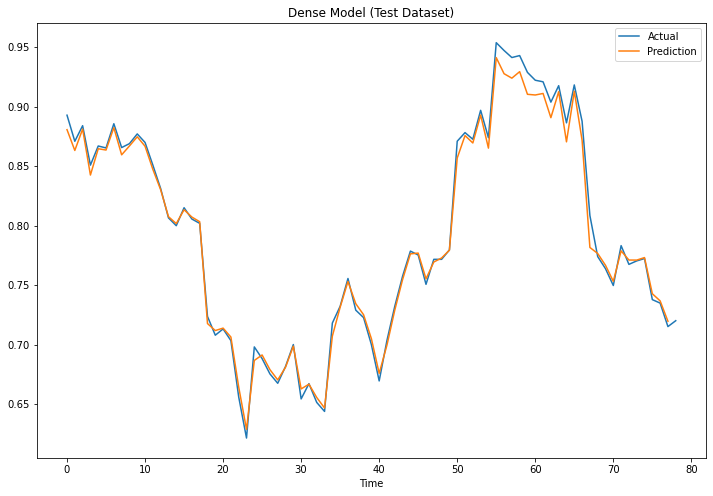

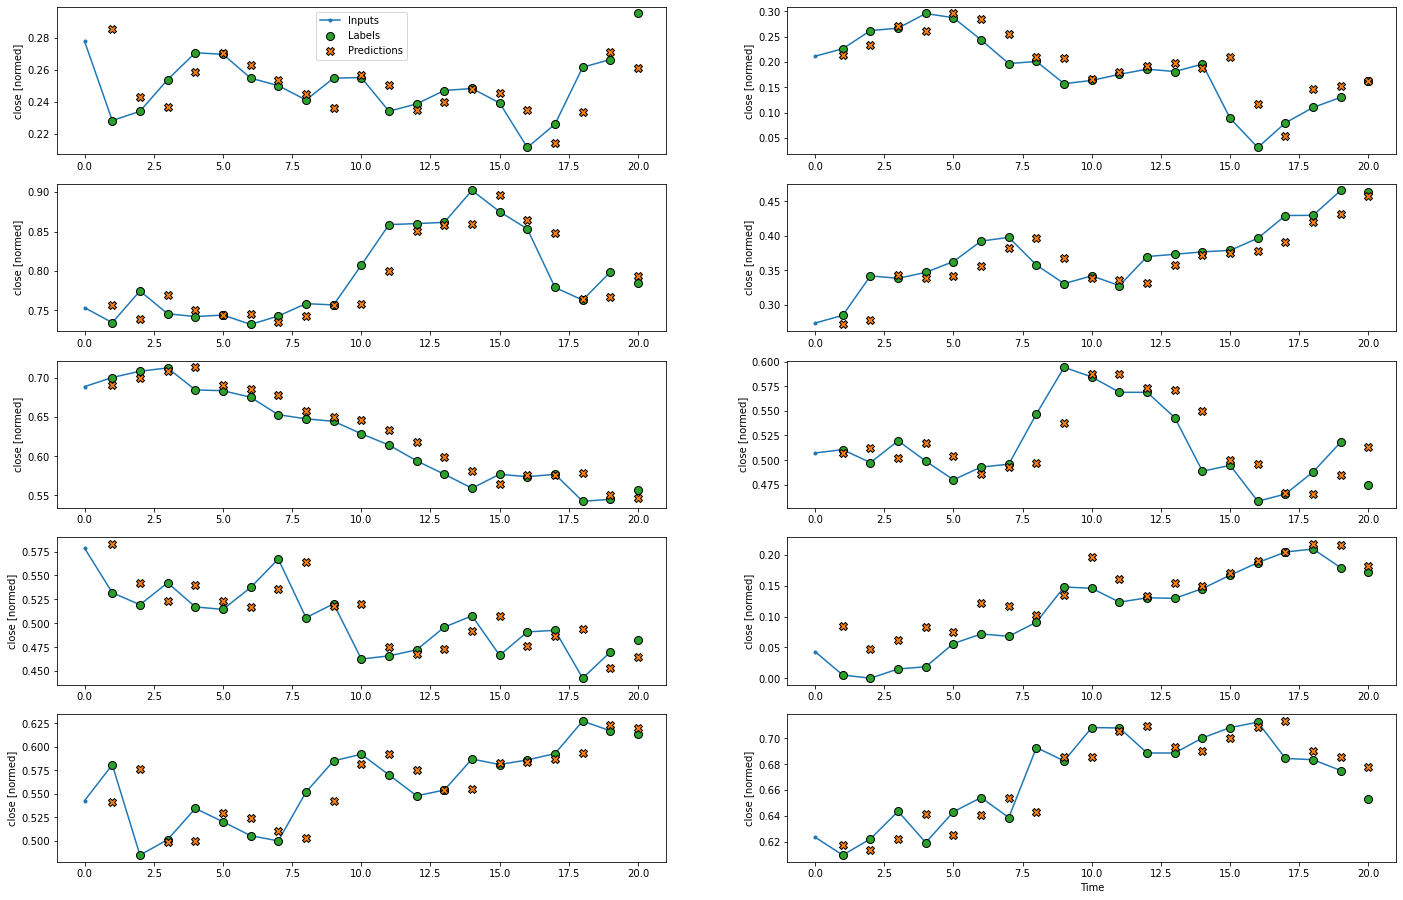

In [25]:
monthly_window.plot_series(dense, title="Dense Model (Test Dataset)", start=-100)
monthly_window.plot(dense)

### CNN

In [26]:
tf.keras.backend.clear_session()

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(20,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [27]:
print("Conv model on `monthly window`")
print('Input shape:', monthly_window.example[0].shape)
print('Output shape:', conv_model(monthly_window.example[0]).shape)

Conv model on `monthly window`
Input shape: (32, 20, 2)
Output shape: (32, 1, 1)


In [28]:
history = compile_and_fit(conv_model, monthly_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(monthly_window.val)
performance['Conv'] = conv_model.evaluate(monthly_window.test, verbose=0)

6/6 [==============================] - 0s 4ms/step - loss: 0.0024 - mean_absolute_error: 0.0388


### RNN LSTM

In [29]:
tf.keras.backend.clear_session()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(120, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [30]:
history = compile_and_fit(lstm_model, monthly_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(monthly_window.val)
performance['LSTM'] = lstm_model.evaluate(monthly_window.test, verbose=0)

6/6 [==============================] - 0s 14ms/step - loss: 8.9276e-04 - mean_absolute_error: 0.0228


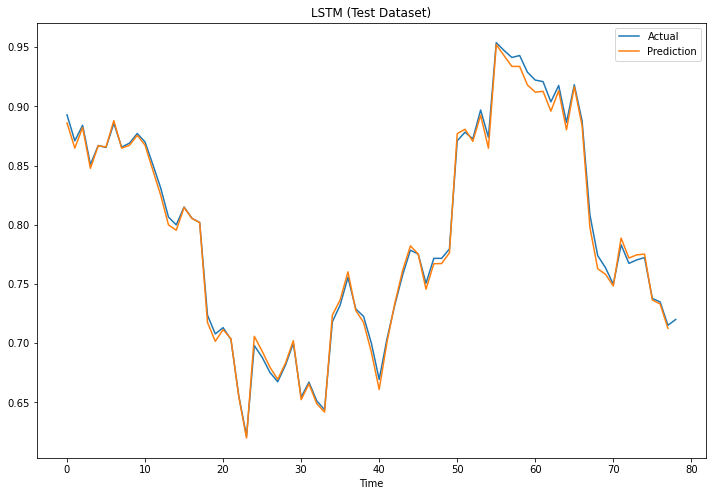

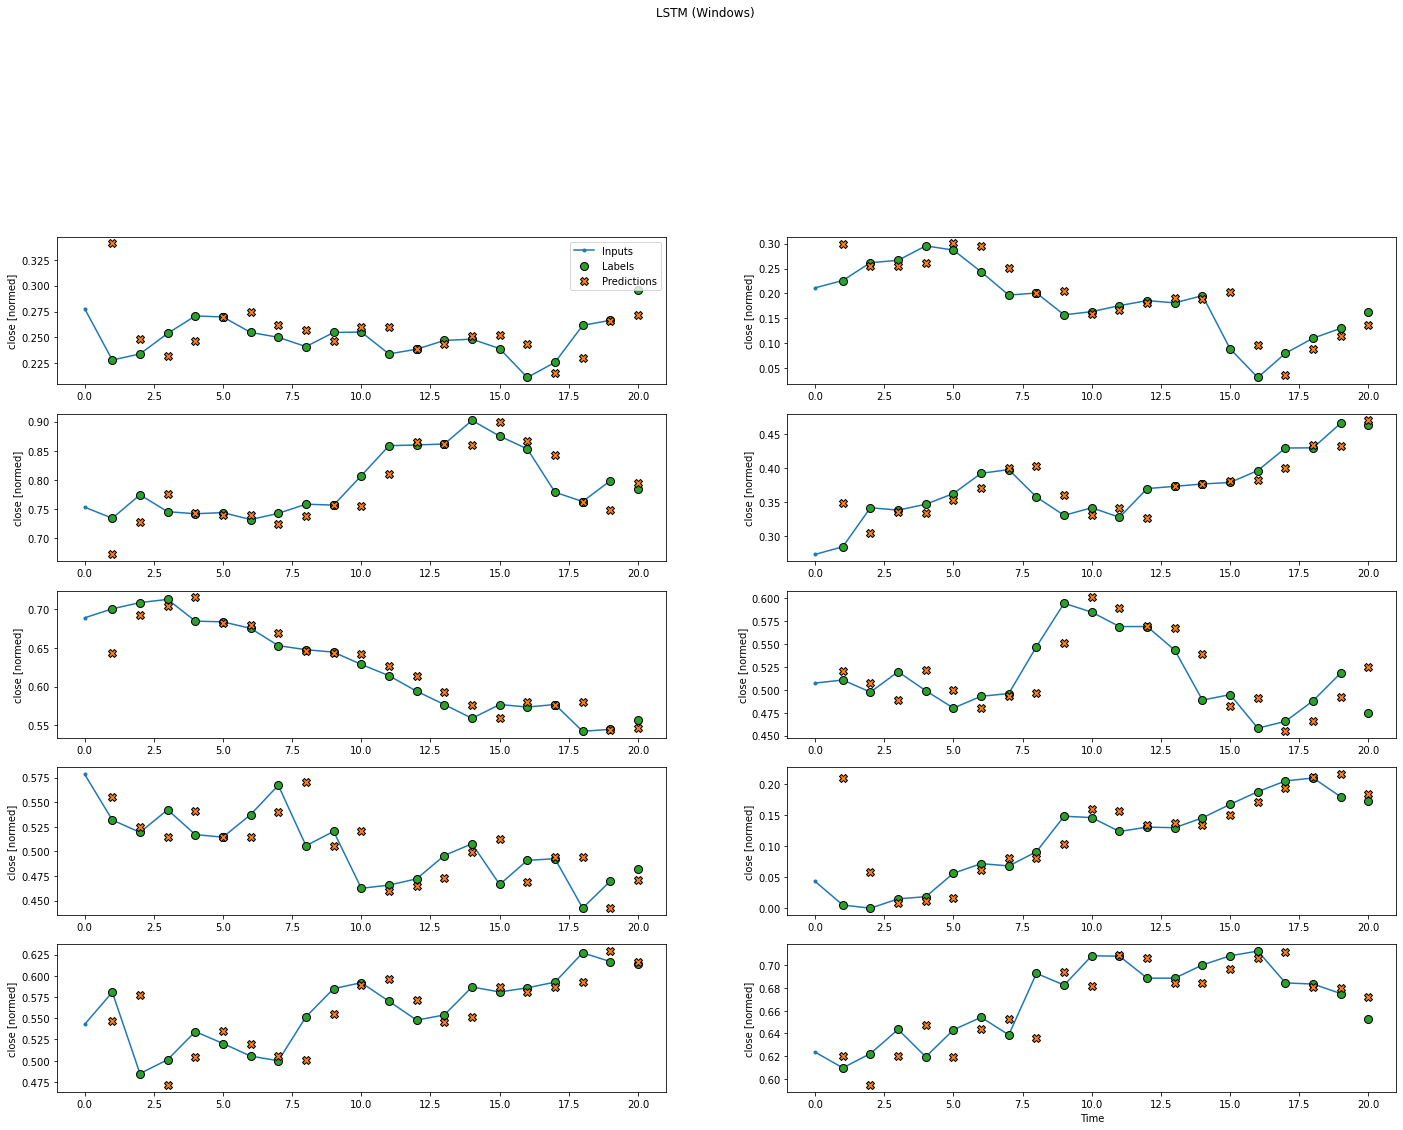

In [31]:
monthly_window.plot_series(lstm_model, title="LSTM (Test Dataset)", start=-100)
monthly_window.plot(lstm_model, title="LSTM (Windows)")

In [32]:
val_df.sample()

,close,log_change
Date,,
2016-11-01,0.507216,0.429121


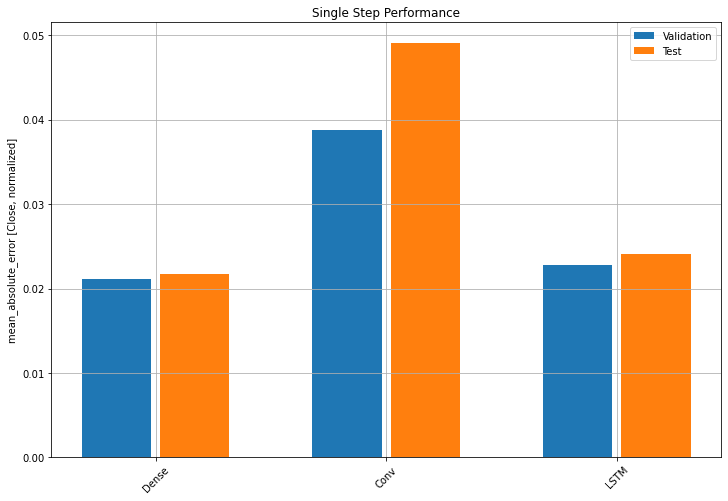

In [33]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.grid()
plt.title('Single Step Performance')
plt.ylabel('mean_absolute_error [Close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [34]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Dense       : 0.0217
Conv        : 0.0491
LSTM        : 0.0240


## Going multi-step

### Predict all timestamps

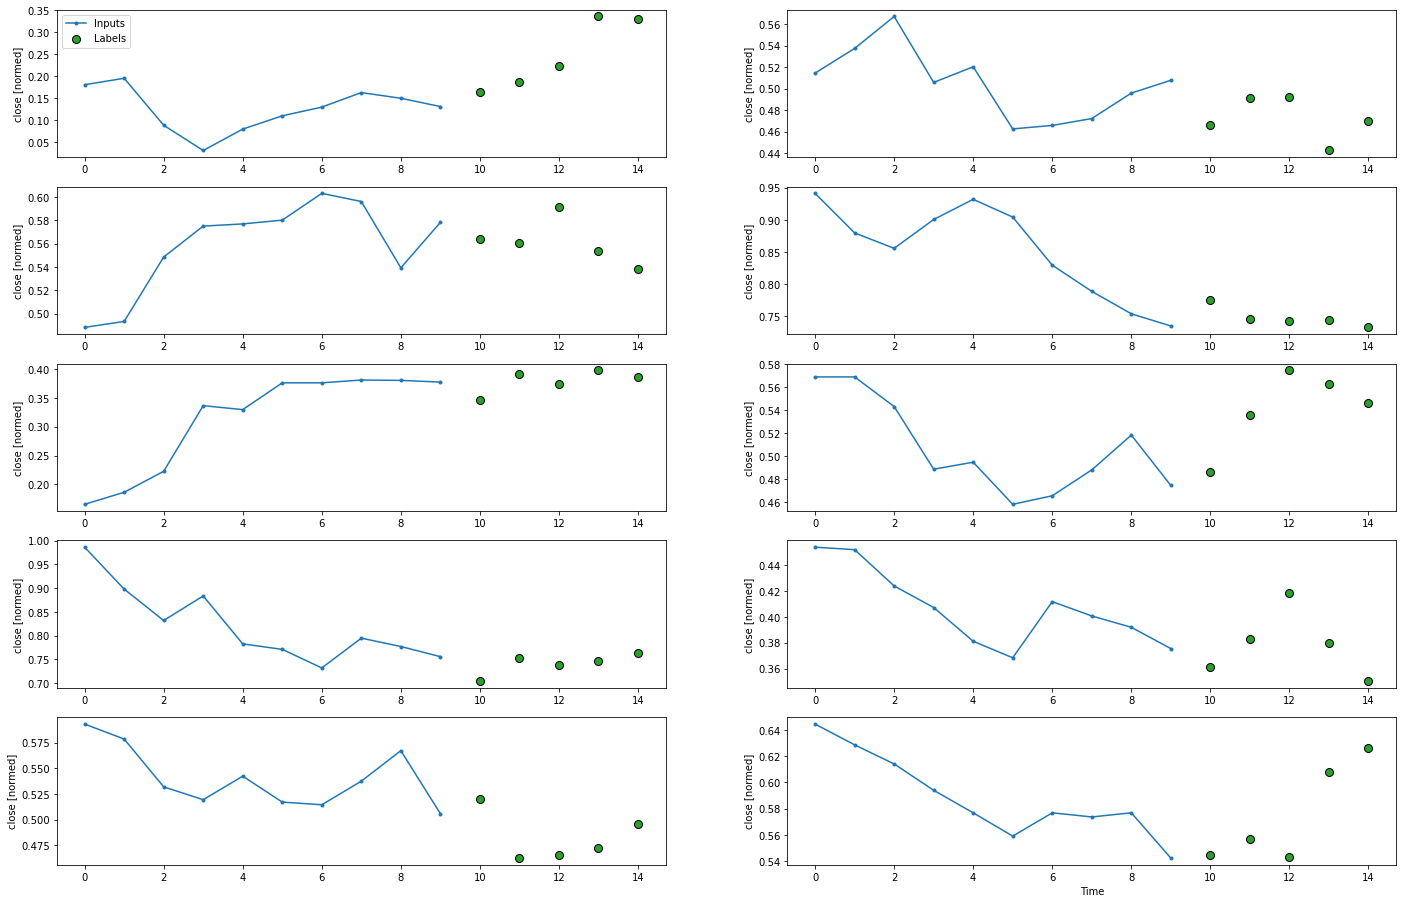

Total window size: 15
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10 11 12 13 14]
Label column name(s): ['close']

In [35]:
OUT_STEPS = 5
multi_window = WindowGenerator(input_width=10, label_width=OUT_STEPS,
                               shift=OUT_STEPS, label_columns=['close'])
multi_window.plot()
multi_window

In [36]:
multi_val_performance = {}
multi_performance = {}

#### Dense model

In [37]:
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                         kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

6/6 [==============================] - 0s 3ms/step - loss: 0.0020 - mean_absolute_error: 0.0347


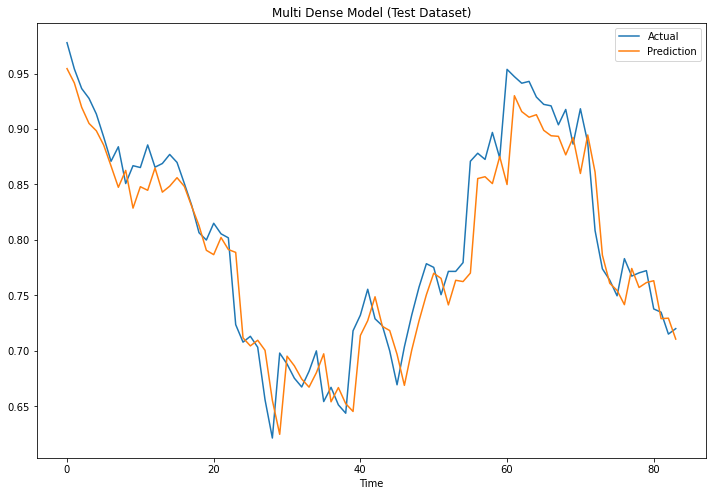

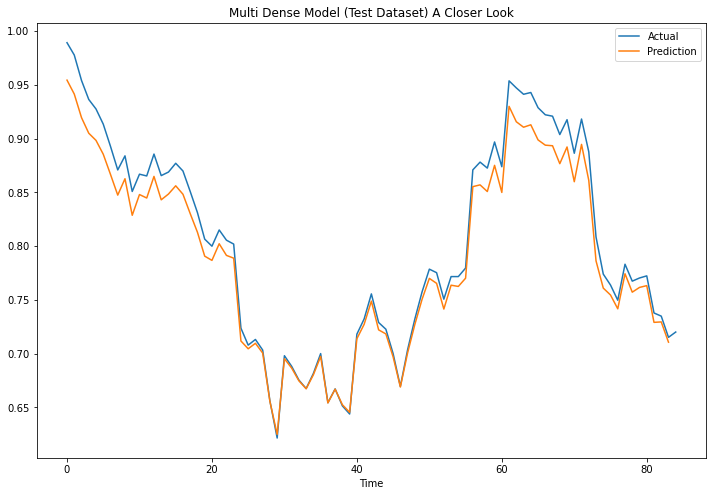

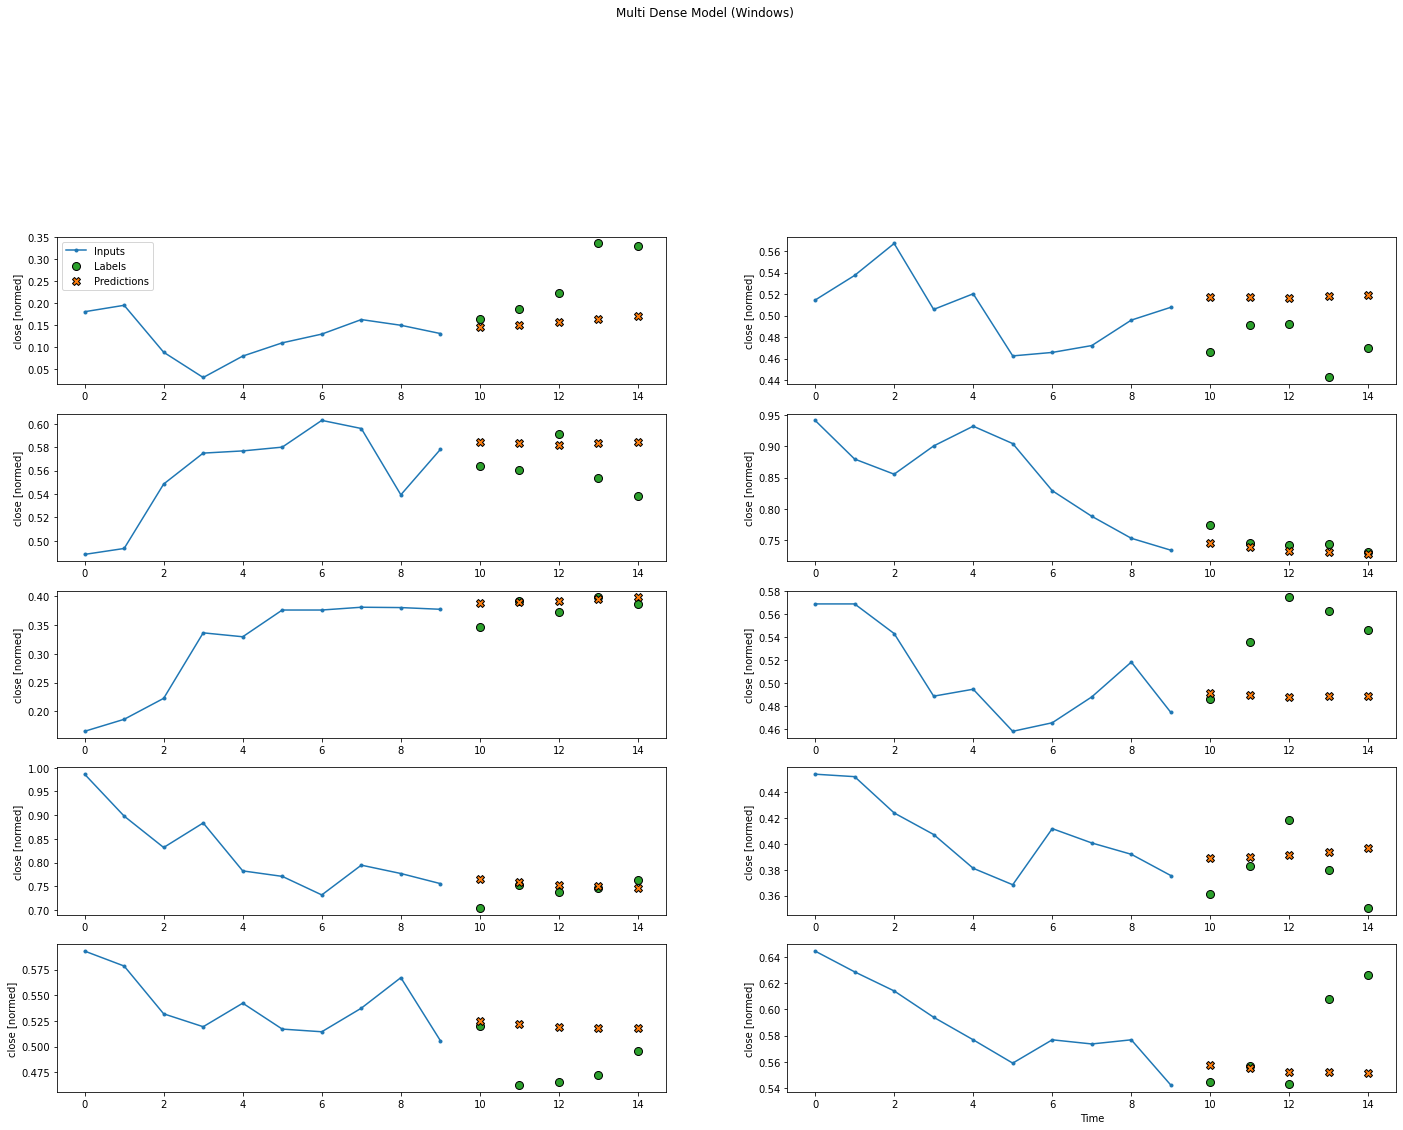

In [38]:
multi_window.plot_series(multi_dense_model, title="Multi Dense Model (Test Dataset)")
multi_window.plot_series(multi_dense_model, title="Multi Dense Model (Test Dataset) A Closer Look", start=-100)
multi_window.plot(multi_dense_model, title="Multi Dense Model (Windows)")

#### CNN

In [39]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(512, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

6/6 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0361


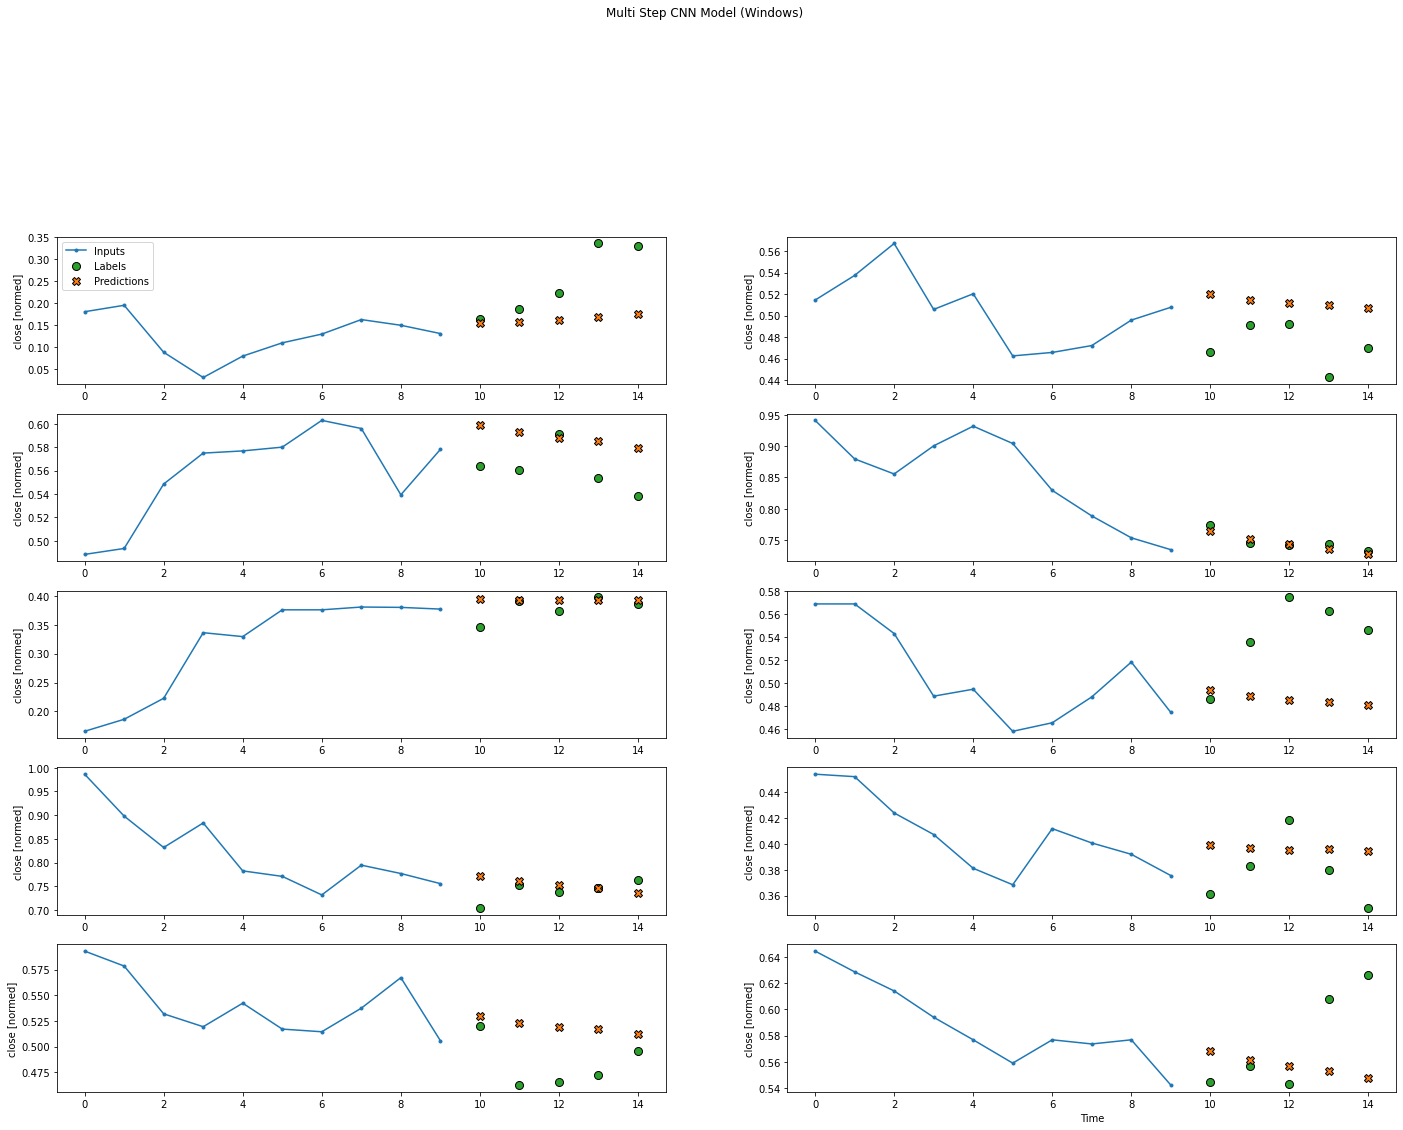

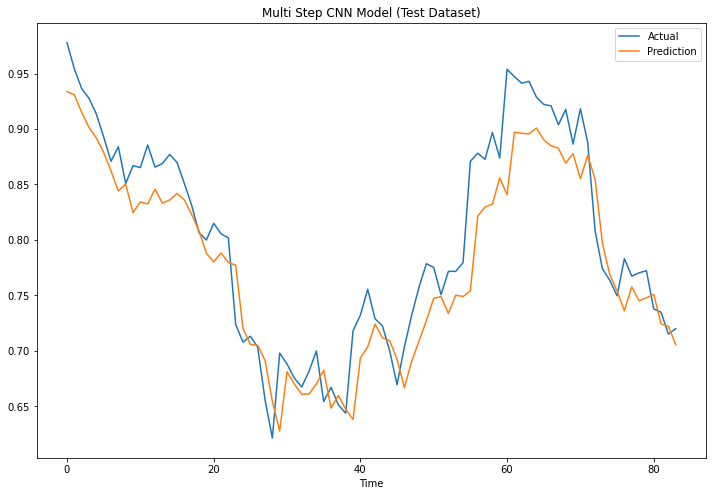

In [40]:
multi_window.plot(multi_conv_model, title="Multi Step CNN Model (Windows)")
multi_window.plot_series(multi_conv_model, title="Multi Step CNN Model (Test Dataset)")

#### RNN LSTM

In [41]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(120, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

6/6 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0515


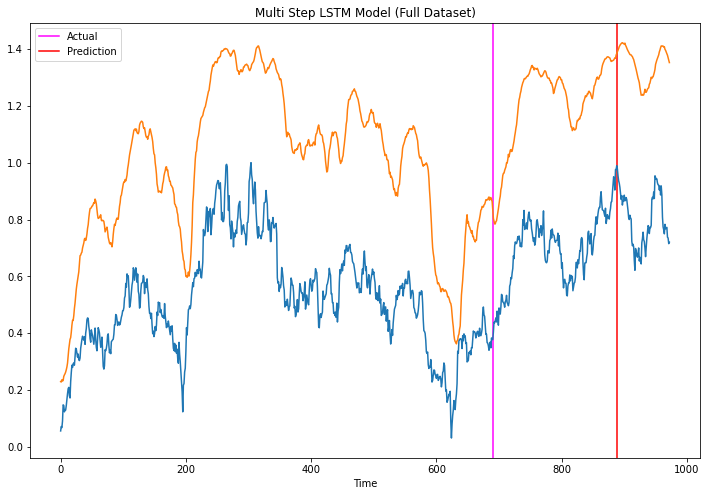

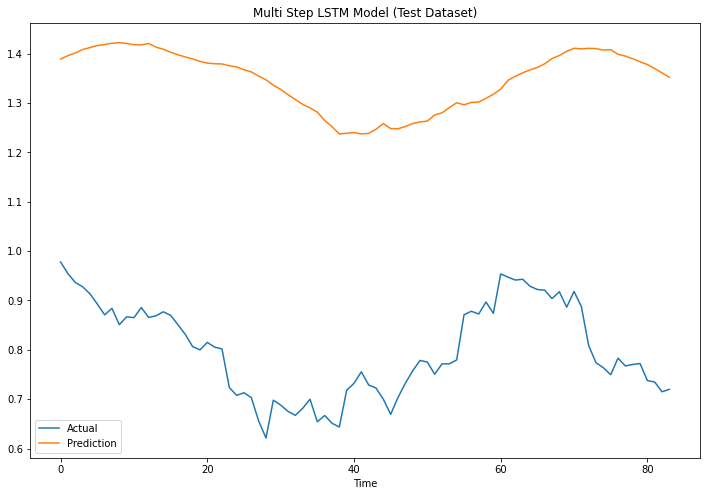

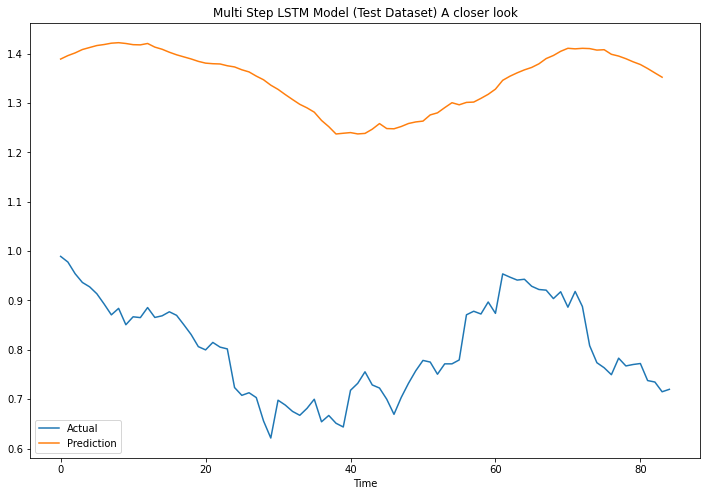

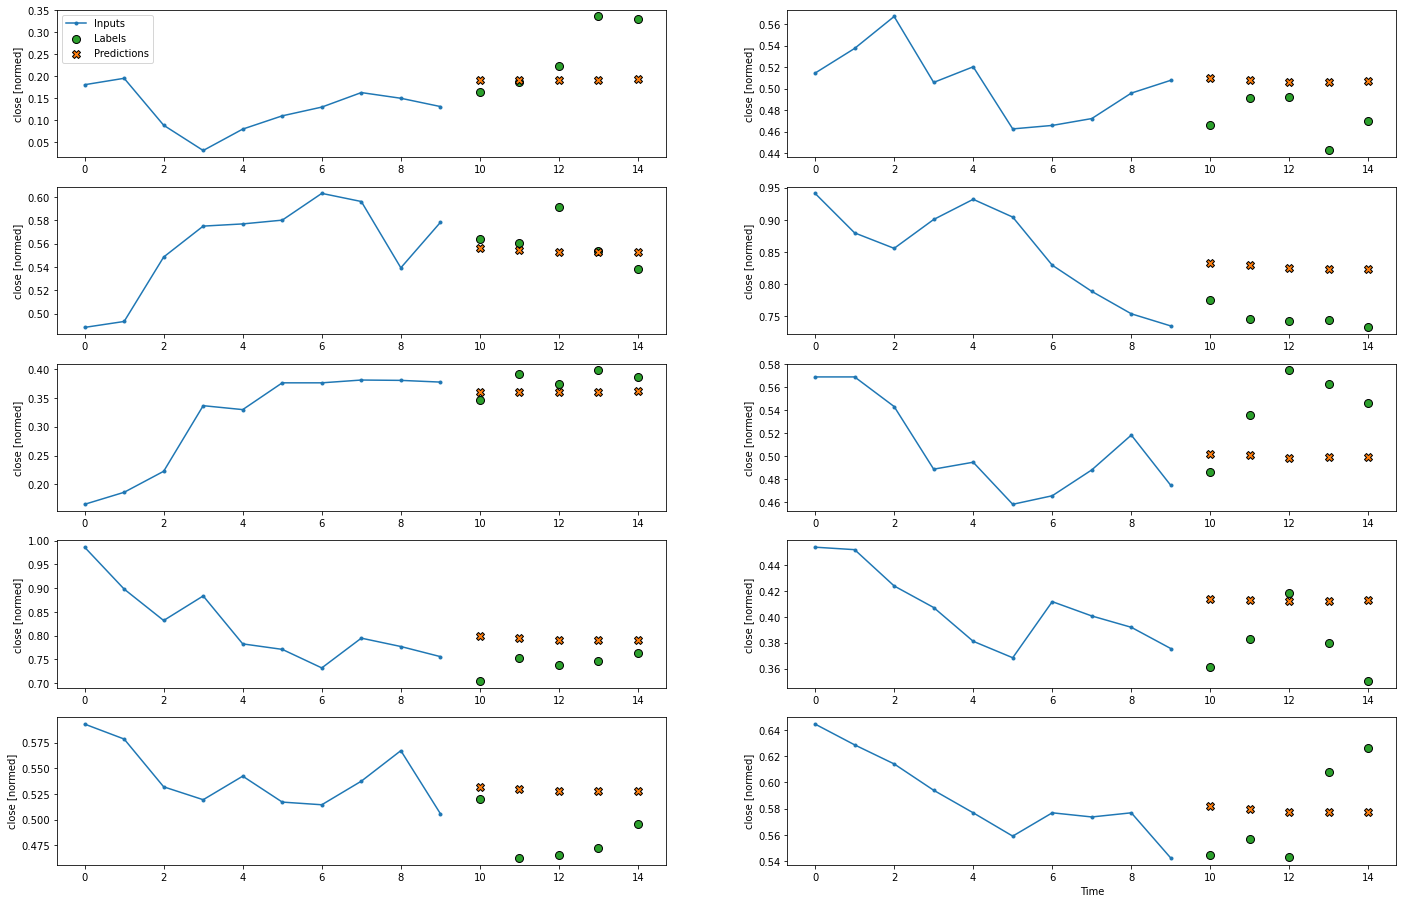

In [42]:
plt.axvline(x=len(train_df), color='magenta')
plt.axvline(x=len(train_df) + len(val_df), color='red')
multi_window.plot_series(multi_lstm_model, title="Multi Step LSTM Model (Full Dataset)", series=df)
multi_window.plot_series(multi_lstm_model, title="Multi Step LSTM Model (Test Dataset)")
multi_window.plot_series(multi_lstm_model, title="Multi Step LSTM Model (Test Dataset) A closer look", start=-100)
multi_window.plot(multi_lstm_model)

### Autoregressive model

In [43]:
class FeedBack(tf.keras.Model):
    def __init__(self, units,out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Wrap the lstm cell in an RNN to simplify the warmup method
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [44]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [45]:
def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)
    
    prediction = self.dense(x)
    return prediction, state
FeedBack.warmup = warmup

In [46]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 2])

In [47]:
def call(self, inputs, training=None):
    predictions = []
    prediction, state = self.warmup(inputs)
    predictions.append(prediction)
    
    for n in range(1, self.out_steps):
        x = prediction
        x, state = self.lstm_cell(x, states=state, training=training)
        prediction = self.dense(x)
        predictions.append(prediction)
        
    predictions = tf.stack(predictions)
    
    predictions = tf.transpose(predictions, [1,0,2])
    return predictions

FeedBack.call = call

In [48]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 5, 2)


In [49]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

# multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
# multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

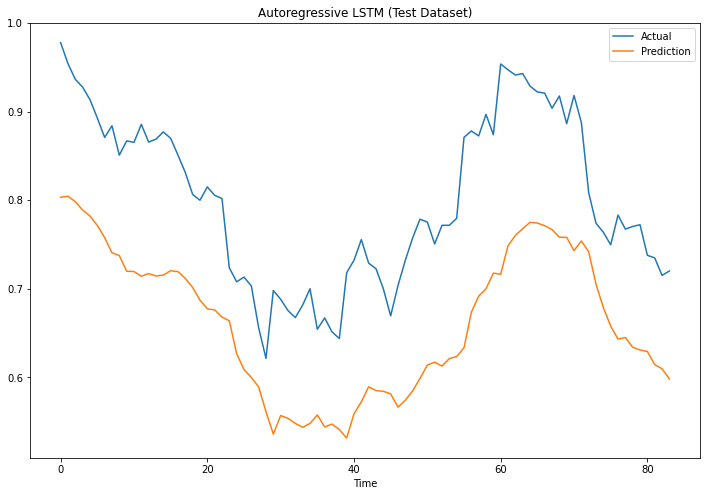

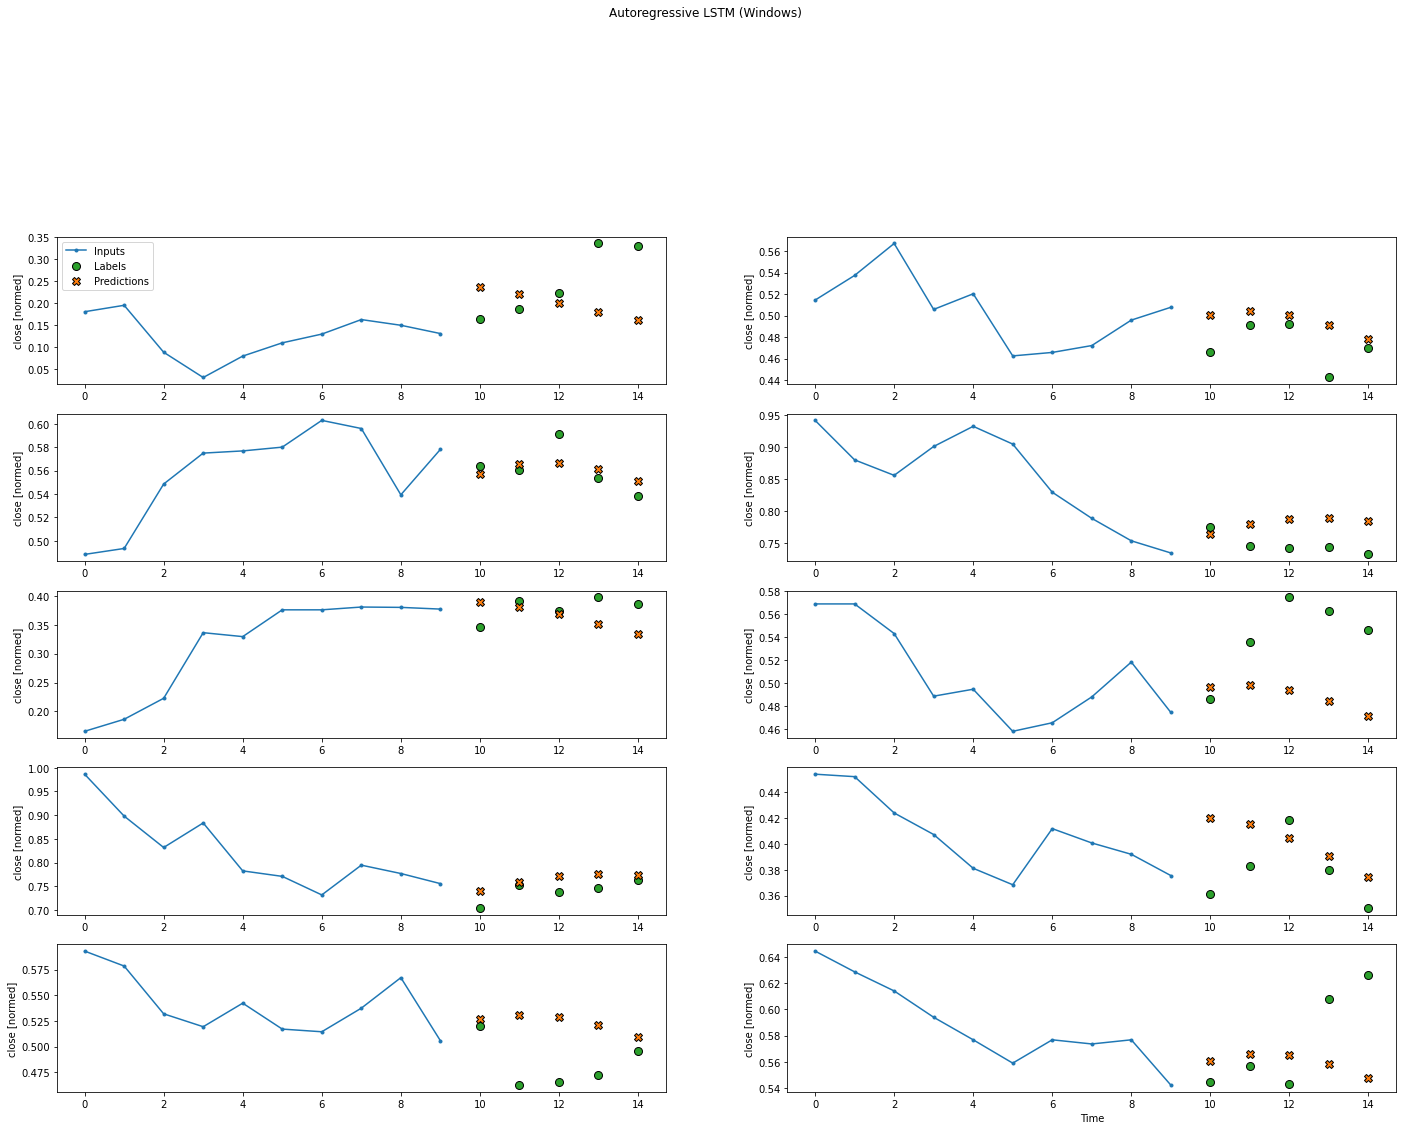

In [50]:
multi_window.plot_series(feedback_model, title="Autoregressive LSTM (Test Dataset)")
multi_window.plot(feedback_model, title="Autoregressive LSTM (Windows)")

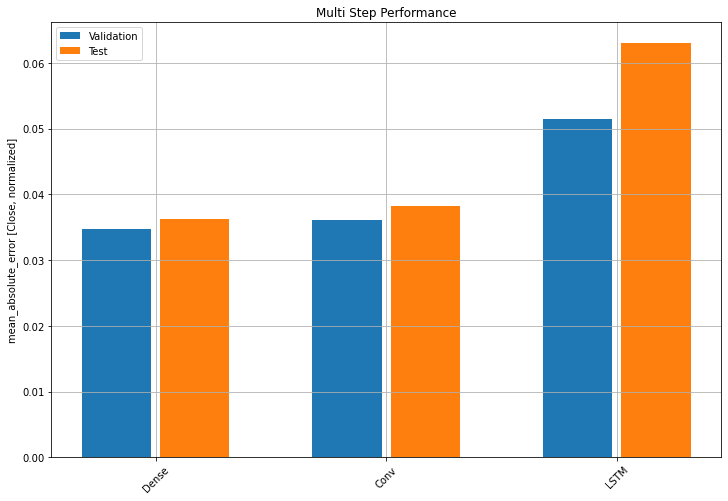

In [51]:
x = np.arange(len(multi_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.grid()
plt.title('Multi Step Performance')
plt.ylabel('mean_absolute_error [Close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()

### ARIMA

In [52]:
# !pip install pmdarima

In [53]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [54]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# df = pd.read_csv('/content/drive/MyDrive/GP/Datasets/huge-stock-market-dataset/Stocks/aal.us.txt', index_col='Date', parse_dates=['Date'], date_parser=dateparse)
arima_df = pd.read_csv('./Datasets/huge-stock-market-dataset/Stocks/acgl.us.txt', index_col='Date', parse_dates=['Date'], date_parser=dateparse)
arima_df = arima_df.rename(columns={'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low', 'Volume': 'volume'})
arima_df = arima_df.drop(columns=['OpenInt'])

<ipython-input-54-7c1f0c90a679>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


#### Check for stationarity

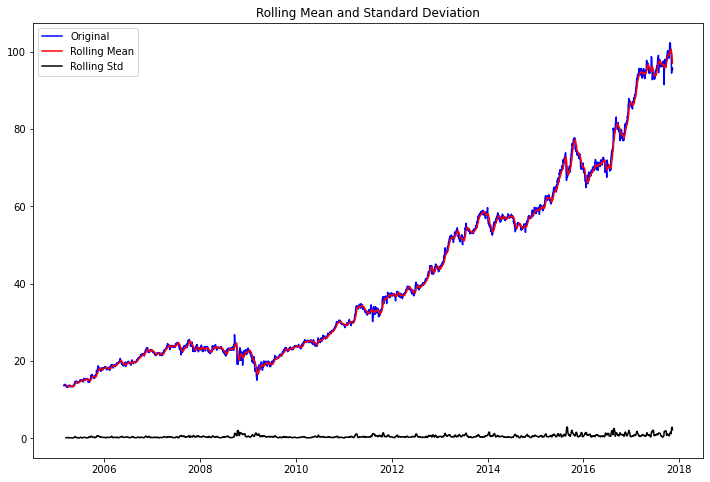

Results of dickey fuller test
Test Statistics                   1.374899
p-value                           0.996997
No. of lags used                  5.000000
Number of observations used    3195.000000
critical value (1%)              -3.432398
critical value (5%)              -2.862445
critical value (10%)             -2.567252
dtype: float64


In [55]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(arima_df['close'])

Since the mean and variance are not flat lines (constants) and the p-value is greater than 0.05, the data is non-stationary

#### Decompose the series

<ipython-input-56-aeeeb1e96885>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(arima_df['close'], model='multiplicative', freq = 30)


<Figure size 864x576 with 0 Axes>

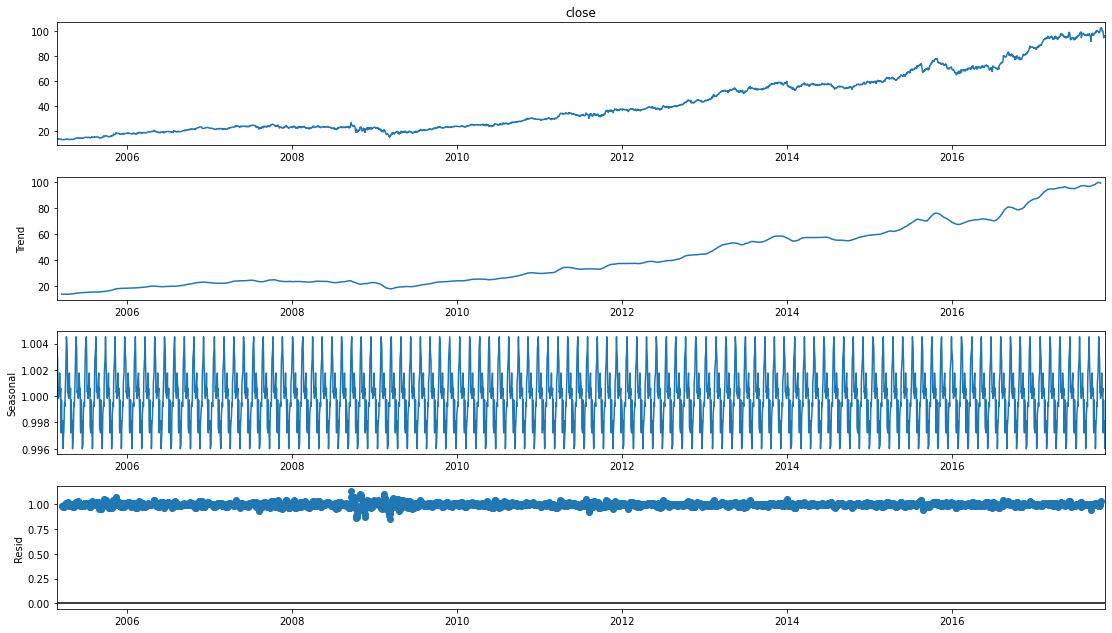

In [56]:
result = seasonal_decompose(arima_df['close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

/home/islam/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
No handles with labels found to put in legend.


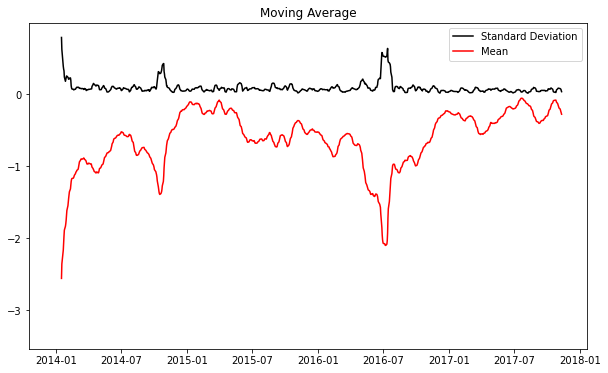

In [57]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

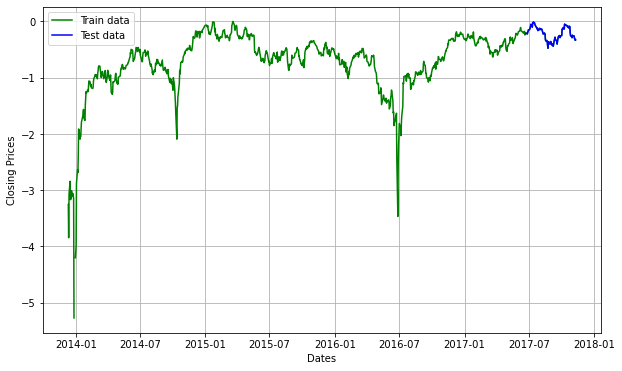

In [58]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [59]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  

print(fitted.summary())

In [ ]:
fc, se, conf = fitted.forecast(321, alpha=0.05)  # 95% conf

In [ ]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# report performance
arima_mse = mean_squared_error(test_data, fc)
print('MSE: '+str(arima_mse))
arima_mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(arima_mae))
arima_rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(arima_rmse))
arima_mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(arima_mape))

We can see that the ARIMA model is showing significanlty lower performance that the multi step LSTM

In [ ]:
x = np.arange(len(multi_performance) + 1)
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
test_mae = [v[metric_index] for v in multi_performance.values()]

# Add ARIMA Performance
xticks = list(performance.keys())
xticks.append("ARIMA")
test_mae.append(float(arima_mae))

# plt.figure(figsize=(12,8))
plt.title('DL vs ARIMA Performance')
plt.ylabel('mean_absolute_error [Close, normalized]')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=xticks,
           rotation=45)
_ = plt.legend()